# Step
1. prepare dataset
2. train model
3. predict the object

cr : 
1. https://towardsdatascience.com/yolov2-object-detection-using-darkflow-83db6aa5cf5f
2. https://towardsdatascience.com/yolov2-to-detect-your-own-objects-soccer-ball-using-darkflow-a4f98d5ce5bf

--------------------

## 1 Prepare Dataset (LabelImg)
- install ตามในนี้ https://github.com/tzutalin/labelImg 
### Steps
1. Build and launch using the instructions above.
2. Click 'Change default saved annotation folder' in Menu/File
3. Click 'Open Dir'
4. Click 'Create RectBox'
5. Click and release left mouse to select a region to annotate the rect box
6. You can use right mouse to drag the rect box to copy or move it

..... Label รูปไปเรื่อยๆจนครบ

## 2 Train Model

เอา weights เดิม กับ config ใหม่ที่เราทำไว้มา train เพิ่มจะได้

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from darkflow.net.build import TFNet
import cv2

In [2]:
options = {"model": "cfg/tiny-yolo-voc-2c.cfg", 
           "load": "bin/tiny-yolo-voc.weights",
           "batch": 10,
           "epoch": 100,
           "gpu": 1.0,
           "train": True,
           "annotation": "./train/Annotations/",
           "dataset": "./train/Images/"}

Defining Model Options & Build the Model

In [3]:
tfnet = TFNet(options)

Parsing ./cfg/tiny-yolo-voc.cfg
Parsing cfg/tiny-yolo-voc-2c.cfg
Loading bin/tiny-yolo-voc.weights ...
Successfully identified 63471556 bytes
Finished in 0.7307629585266113s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  l

Training the Model

In [4]:
tfnet.train()


cfg/tiny-yolo-voc-2c.cfg parsing ./train/Annotations/
Parsing for ['idcard', 'person_face'] 
[====================>]100%  0.xml
Statistics:
person_face: 172
idcard: 187
Dataset size: 200
Dataset of 200 instance(s)
Training statistics: 
	Learning rate : 1e-05
	Batch size    : 10
	Epoch number  : 100
	Backup every  : 2000
step 1 - loss 115.71382141113281 - moving ave loss 115.71382141113281
step 2 - loss 114.7573013305664 - moving ave loss 115.61816940307618
step 3 - loss 113.31331634521484 - moving ave loss 115.38768409729005
step 4 - loss 112.81703186035156 - moving ave loss 115.1306188735962
step 5 - loss 112.48786926269531 - moving ave loss 114.86634391250612
step 6 - loss 111.48885345458984 - moving ave loss 114.52859486671451
step 7 - loss 111.04705810546875 - moving ave loss 114.18044119058995
step 8 - loss 110.61322021484375 - moving ave loss 113.82371909301533
step 9 - loss 110.0135498046875 - moving ave loss 113.44270216418255
step 10 - loss 109.47509765625 - moving ave loss 1

In [5]:
tfnet.savepb()

# Loading from the Latest Checkpoint
This cell shows how to load custom trained model from the checkpoint. It will easy your work.

1. model: the model configuration that you used (*.cfg)

2. load: set -1. In this way, the latest checkpoint will be loaded.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from darkflow.net.build import TFNet
import cv2

In [3]:
options2 = {"model": "cfg/tiny-yolo-voc-2c.cfg",
           "load": -1,
           "gpu": 1.0}

tfnet2 = TFNet(options2)
tfnet2.load_from_ckpt()

Parsing cfg/tiny-yolo-voc-2c.cfg
Loading None ...
Finished in 0.00015497207641601562s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13

## 3 Predict the object

In [4]:
def boxing(original_img , predictions):
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))
        
        if confidence > 0:
            newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 3)
            newImage = cv2.putText(newImage, label, (top_x, top_y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
        
    return newImage

In [5]:
import pprint as pp

original_img = cv2.imread("train/Images/1008.jpg")
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
results = tfnet2.return_predict(original_img)
results

[{'label': 'idcard',
  'confidence': 0.74704874,
  'topleft': {'x': 249, 'y': 625},
  'bottomright': {'x': 567, 'y': 839}},
 {'label': 'person_face',
  'confidence': 0.5668472,
  'topleft': {'x': 136, 'y': 92},
  'bottomright': {'x': 556, 'y': 634}}]

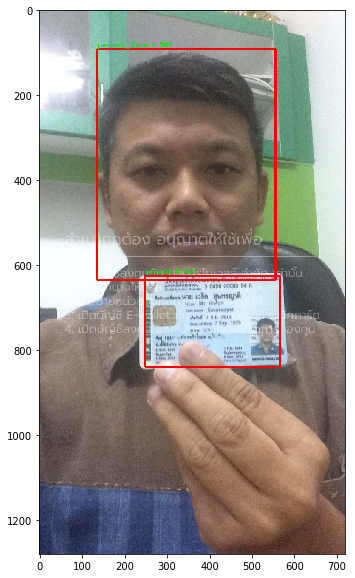

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(boxing(original_img, results))

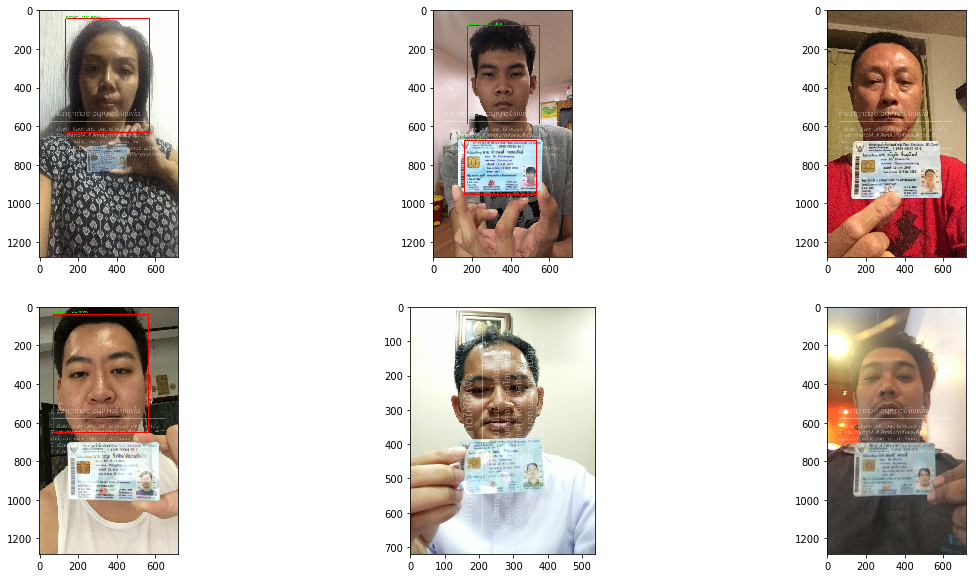

In [7]:
from math import ceil

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i in range(1020,1026):
    original_img = cv2.imread("train/Images/" + str(i) + ".jpg")
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    results = tfnet2.return_predict(original_img)
    
    ax[ceil((i-1020)/3)-1, i%3].imshow(boxing(original_img, results))

## Predicting on a Video

In [8]:
cap = cv2.VideoCapture('./sample_video/IMG_2910.MOV')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) 

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('./sample_video/output.mp4',fourcc, 20.0, (int(width), int(height)))

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)      
        results = tfnet2.return_predict(frame)
        
        new_frame = boxing(frame, results)

        # Display the resulting frame
        out.write(new_frame)
        cv2.imshow('frame', new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# When everything done, release the capture
cap.release()
out.release()
cv2.waitKey(5)
cv2.destroyAllWindows()